In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.utils import class_weight
sys.path.append('./src')
import engineer_features as ef

c:\Users\lesli\Documents\GitHub\BT4012-Group-15-Ecommerce-Fraud\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('Fraudulent_E-Commerce_Transaction_Data_2.csv')

In [3]:
X_train, X_test, y_train, y_test = ef.engineer_features(data, use_linear_model=False, use_smote=False)
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
device = torch.device("cpu")

Strategy: Using ORIGINAL amount. Dropping 'log_transaction_amount'.
Feature engineering complete.
Skipping SMOTE. Returning standard train/test split.
Training features shape: (18907, 24)
Test features shape: (4727, 24)


c:\Users\lesli\Documents\GitHub\BT4012-Group-15-Ecommerce-Fraud\src\engineer_features.py:99: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['customer_avg_spend_before_tx'].fillna(0, inplace=True)


In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1) 
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [5]:
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
pos_weight = torch.tensor(weights[1] / weights[0], dtype=torch.float32).to(device)
print(f"Calculated pos_weight for loss function: {pos_weight.item():.2f}")

Calculated pos_weight for loss function: 18.33


In [6]:
N_FEATURES = X_train_scaled.shape[1]
EPOCHS = 50 
BATCH_SIZE = 128

In [7]:
class DNN(nn.Module):
    def __init__(self, trial):
        super(DNN, self).__init__()
        layers_list = []
        
        n_layers = trial.suggest_int('n_layers', 1, 3)
        in_features = N_FEATURES
        
        for i in range(n_layers):
            out_features = trial.suggest_int(f'units_layer_{i}', 64, 256, log=True)
            layers_list.append(nn.Linear(in_features, out_features))
            layers_list.append(nn.ReLU())
            dropout_rate = trial.suggest_float(f'dropout_layer_{i}', 0.2, 0.4)
            layers_list.append(nn.Dropout(dropout_rate))
            in_features = out_features 
            
        layers_list.append(nn.Linear(in_features, 1))
        
        self.layers = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.layers(x)

In [8]:
def objective(trial):
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(
        X_train_tensor, y_train_tensor, test_size=0.2, random_state=ef.RANDOM_SEED
    )
    
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    val_dataset = TensorDataset(X_val_fold, y_val_fold)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = DNN(trial).to(device)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 5e-3, log=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_val_auc = 0
    patience_counter = 0
    
    for epoch in range(EPOCHS):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_preds = []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_preds.extend(torch.sigmoid(output).cpu().numpy())
        
        val_auc = roc_auc_score(y_val_fold.cpu().numpy(), val_preds)
        
        trial.report(val_auc, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 5: 
                break
                
    return best_val_auc

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(f"Best Validation AUC (from CV): {study.best_value:.4f}")
print("Best Parameters:")
print(study.best_params)

[I 2025-11-16 18:14:51,092] A new study created in memory with name: no-name-b20a60d3-5ae6-4a02-8d89-e6b14b25f5ac
[I 2025-11-16 18:14:53,729] Trial 0 finished with value: 0.8111362367392516 and parameters: {'n_layers': 2, 'units_layer_0': 185, 'dropout_layer_0': 0.2228995162182885, 'units_layer_1': 76, 'dropout_layer_1': 0.30181402390243345, 'learning_rate': 0.0017126438953813192}. Best is trial 0 with value: 0.8111362367392516.
[I 2025-11-16 18:14:55,114] Trial 1 finished with value: 0.8107733109994415 and parameters: {'n_layers': 1, 'units_layer_0': 125, 'dropout_layer_0': 0.33350697065295254, 'learning_rate': 0.0017730109938423888}. Best is trial 0 with value: 0.8111362367392516.
[I 2025-11-16 18:14:56,480] Trial 2 finished with value: 0.8088442211055276 and parameters: {'n_layers': 1, 'units_layer_0': 235, 'dropout_layer_0': 0.31045739897205904, 'learning_rate': 0.003052721418651953}. Best is trial 0 with value: 0.8111362367392516.
[I 2025-11-16 18:14:58,153] Trial 3 finished with 

Best Validation AUC (from CV): 0.8226
Best Parameters:
{'n_layers': 1, 'units_layer_0': 214, 'dropout_layer_0': 0.37624301624935674, 'learning_rate': 0.001257207927474604}


In [10]:
best_trial = study.best_trial
final_model = DNN(best_trial).to(device) 

final_lr = best_trial.params['learning_rate']
final_optimizer = optim.Adam(final_model.parameters(), lr=final_lr)
final_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

final_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
final_train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

FINAL_EPOCHS = 15 
final_model.train()
for epoch in range(FINAL_EPOCHS):
    for data, target in final_train_loader:
        data, target = data.to(device), target.to(device)
        final_optimizer.zero_grad()
        output = final_model(data)
        loss = final_loss_fn(output, target)
        loss.backward()
        final_optimizer.step()

In [11]:
final_model.eval()
with torch.no_grad():
    y_pred_proba_tensor = torch.sigmoid(final_model(X_test_tensor))
    
y_pred_proba = y_pred_proba_tensor.cpu().numpy().ravel()
y_pred = (y_pred_proba > 0.5).astype(int)
y_test_numpy = y_test.values

Accuracy (Test Set): 0.8183
ROC-AUC Score (Test Set): 0.7479

Classification Report (Test Set):
               precision    recall  f1-score   support

Not Fraud (0)       0.98      0.83      0.90      4483
    Fraud (1)       0.16      0.61      0.26       244

     accuracy                           0.82      4727
    macro avg       0.57      0.72      0.58      4727
 weighted avg       0.93      0.82      0.86      4727


Confusion Matrix (Test Set):


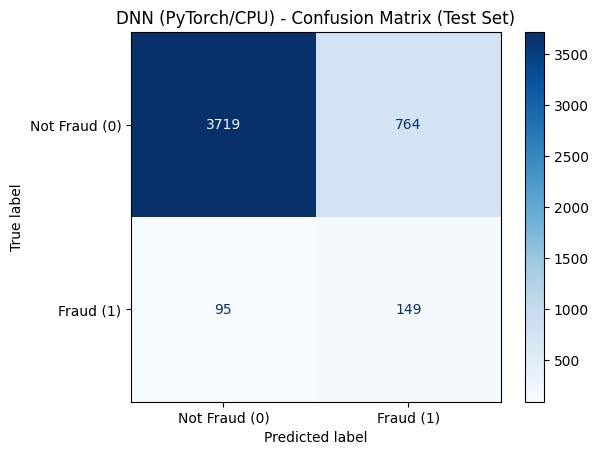

In [12]:
accuracy = accuracy_score(y_test_numpy, y_pred)
roc_auc = roc_auc_score(y_test_numpy, y_pred_proba) 
print(f"Accuracy (Test Set): {accuracy:.4f}")
print(f"ROC-AUC Score (Test Set): {roc_auc:.4f}")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test_numpy, y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test_numpy, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud (0)', 'Fraud (1)'])
disp.plot(cmap='Blues')
plt.title("DNN (PyTorch/CPU) - Confusion Matrix (Test Set)")
plt.show()